# Installing the required packages

In [2]:
!pip install tensorflow

In [3]:
!pip install efficientnet

# Importing the required packages

In [4]:
import numpy as np
import pandas as pd
import pydicom
import os
import collections
import sys
import glob as gb
import random
import cv2
import itertools
import json
from PIL import Image
import tensorflow as tf
import multiprocessing
from math import ceil, floor
from copy import deepcopy
from tqdm.notebook import tqdm
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping

In [5]:
import keras
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
import efficientnet.keras as efn 

In [6]:

from keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm

from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter


# Identifying dataset path

In [7]:
# Folders
dataset_path = os.listdir('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset')

test_path = '/kaggle/input/skin-cancer-malignant-vs-benign/'
train_path = '/kaggle/input/skin-cancer-malignant-vs-benign/'

print (dataset_path)
print("Types of classes labels found: ", len(dataset_path),'\n')

print (test_path)
print("Types of classes labels found: ", len(test_path),'\n')

print (train_path)
print("Types of classes labels found: ", len(train_path))

['test', 'train']
Types of classes labels found:  2 

/kaggle/input/skin-cancer-malignant-vs-benign/
Types of classes labels found:  46 

/kaggle/input/skin-cancer-malignant-vs-benign/
Types of classes labels found:  46


# Preprocessing

In [8]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign',380))
malign_train = np.array(Dataset_loader('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/malignant',380))
benign_test = np.array(Dataset_loader('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign',380))
malign_test = np.array(Dataset_loader('/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/malignant',380))

100%|██████████| 500/500 [00:02<00:00, 187.39it/s]


# Label creation

In [9]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Splitting

In [10]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Displaying set of images

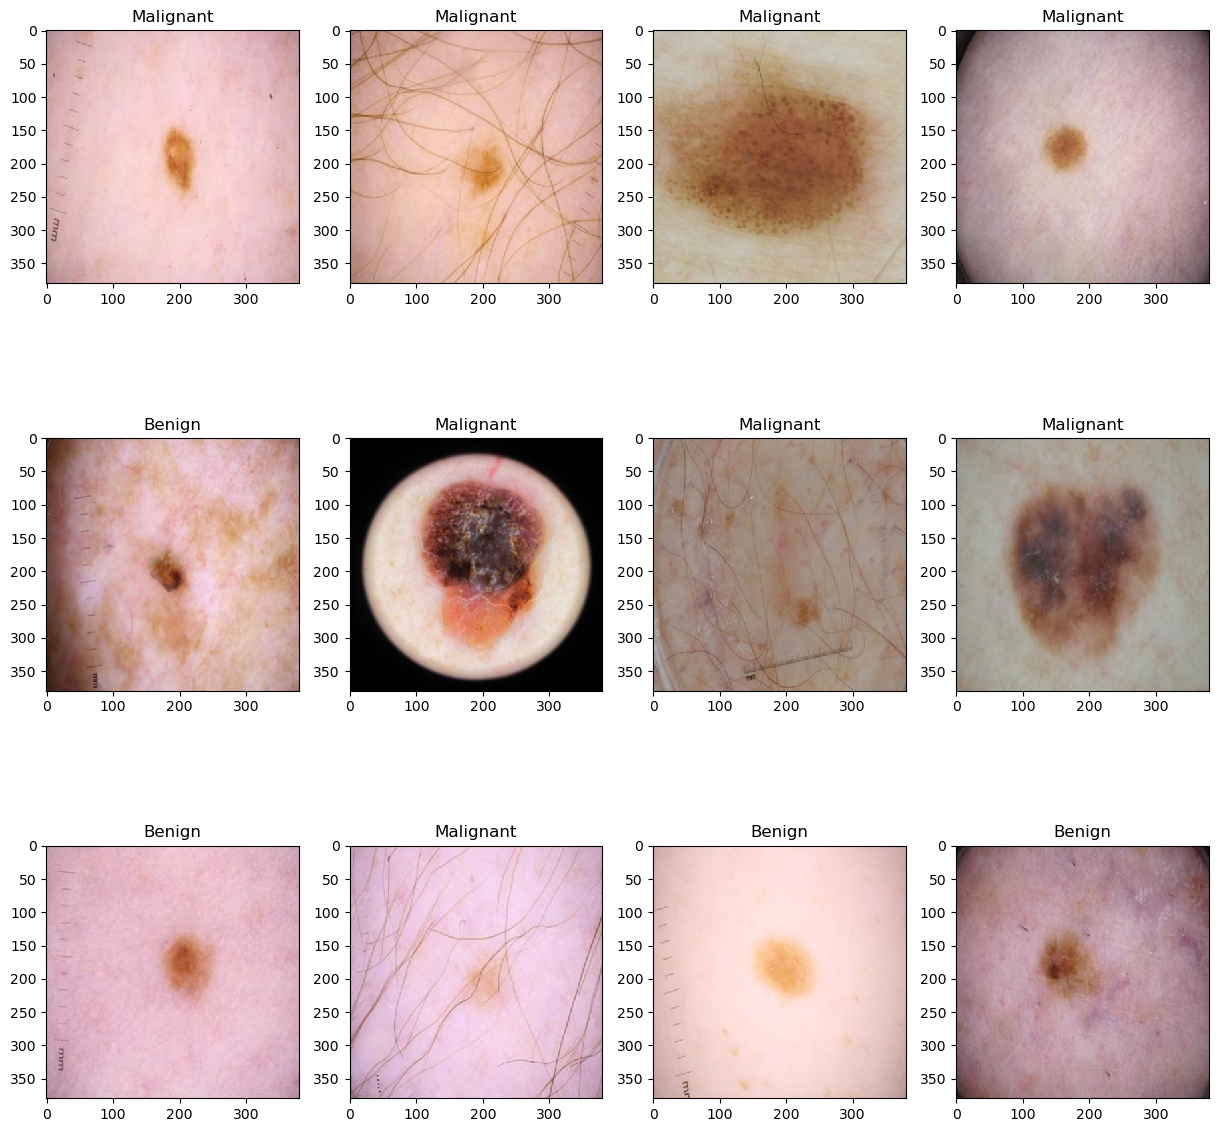

In [11]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [12]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

In [13]:
# Constants
no_classes= 2
size=380
CHANNELS = 3
SHAPE = (size, size, CHANNELS) #	input images of shape (380,380,3) EB4

In [14]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [21]:
    efficientnetB4 = efn.EfficientNetB4(weights = 'imagenet',
                            include_top = False,
                            pooling = 'avg',
                            input_shape = SHAPE)
    for layer in efficientnetB4.layers[:461]:
        layer.trainable = False
    for i, layer in enumerate(efficientnetB4.layers):
        print(i, layer.name, layer.trainable)
        
    top_model = efficientnetB4.output
    top_model = tf.keras.layers.Flatten()(top_model)
    top_model = tf.keras.layers.Dense(512, activation='relu')(top_model)
    top_model = tf.keras.layers.Dropout(0.2)(top_model)
    top_model = tf.keras.layers.Dense(64, activation='relu')(top_model)
    top_model = tf.keras.layers.Dropout(0.2)(top_model)
    output_layer = tf.keras.layers.Dense(2, activation='softmax')(top_model)

    efficientnetB4 = Models.Model(inputs=efficientnetB4.input, outputs=output_layer)
    efficientnetB4.compile(optimizer=Optimizer.Adam(lr=0.01),loss='binary_crossentropy' ,metrics=['accuracy'])
efficientnetB4.summary()

0 input_3 False
1 stem_conv False
2 stem_bn False
3 stem_activation False
4 block1a_dwconv False
5 block1a_bn False
6 block1a_activation False
7 block1a_se_squeeze False
8 block1a_se_reshape False
9 block1a_se_reduce False
10 block1a_se_expand False
11 block1a_se_excite False
12 block1a_project_conv False
13 block1a_project_bn False
14 block1b_dwconv False
15 block1b_bn False
16 block1b_activation False
17 block1b_se_squeeze False
18 block1b_se_reshape False
19 block1b_se_reduce False
20 block1b_se_expand False
21 block1b_se_excite False
22 block1b_project_conv False
23 block1b_project_bn False
24 block1b_drop False
25 block1b_add False
26 block2a_expand_conv False
27 block2a_expand_bn False
28 block2a_expand_activation False
29 block2a_dwconv False
30 block2a_bn False
31 block2a_activation False
32 block2a_se_squeeze False
33 block2a_se_reshape False
34 block2a_se_reduce False
35 block2a_se_expand False
36 block2a_se_excite False
37 block2a_project_conv False
38 block2a_project_bn Fal

In [16]:

filepath="/kaggle/working/"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=5,verbose=1, min_lr=1e-7)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
trained4 = efficientnetB4.fit(x_train,y_train,validation_split=0.3,epochs=10,callbacks=[reduce_lr,es],batch_size=128)

Epoch 1/10
43/43 [==============================] - 3089s 72s/step - loss: 0.7465 - accuracy: 0.5030 - val_loss: 0.6939 - val_accuracy: 0.4970 - lr: 0.0010
Epoch 2/10
43/43 [==============================] - 3057s 72s/step - loss: 0.6955 - accuracy: 0.5201 - val_loss: 0.6933 - val_accuracy: 0.4983 - lr: 0.0010
Epoch 3/10
43/43 [==============================] - 3072s 72s/step - loss: 0.7005 - accuracy: 0.5249 - val_loss: 0.6933 - val_accuracy: 0.4983 - lr: 0.0010
Epoch 4/10
43/43 [==============================] - 3017s 71s/step - loss: 0.6944 - accuracy: 0.5249 - val_loss: 0.6935 - val_accuracy: 0.4983 - lr: 0.0010
Epoch 5/10
43/43 [==============================] - 3027s 71s/step - loss: 0.6909 - accuracy: 0.5288 - val_loss: 0.6936 - val_accuracy: 0.4983 - lr: 0.0010
Epoch 6/10
43/43 [==============================] - 3031s 71s/step - loss: 0.6940 - accuracy: 0.5290 - val_loss: 0.6994 - val_accuracy: 0.5022 - lr: 0.0010
Epoch 7/10
43/43 [==============================] - 3078s 72s/st